In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import wasserstein_distance  # Import Wasserstein distance

# Function to create the GAN
def build_gan(latent_dim):
    generator = models.Sequential([
        layers.Dense(128, input_shape=(latent_dim,), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(X_train.shape[1], activation='sigmoid')  # Output layer
    ])

    discriminator = models.Sequential([
        layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Output layer
    ])

    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = models.Model(gan_input, gan_output)

    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return generator, discriminator, gan

# Function to calculate Wasserstein distance
def calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2):
    # Compute the Wasserstein distance
    distance = wasserstein_distance(synthetic_data1.flatten(), synthetic_data2.flatten())
    return distance

# dataset loading
df = pd.read_csv('/Users/farhatlamiabarsha/Downloads/archive/Fraud_Data.csv')

# Preprocess data 
columns_to_drop = ['user_id', 'signup_time', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['year'] = df['purchase_time'].dt.year
df['month'] = df['purchase_time'].dt.month
df['day'] = df['purchase_time'].dt.day
df['hour'] = df['purchase_time'].dt.hour
df['minute'] = df['purchase_time'].dt.minute
df['second'] = df['purchase_time'].dt.second
df = df.drop('purchase_time', axis=1)
new_column_order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'purchase_value', 'class']
df = df[new_column_order]

# Downsampling the majority class (non-fraud) to match the number of fraud cases
non_fraud = df[df['class'] == 0].sample(df['class'].value_counts()[1])
fraud = df[df['class'] == 1]
df = pd.concat([fraud, non_fraud], ignore_index=True)

# Split the dataset into dependent and independent variables
X = df.drop(['class'], axis=1)
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Build and train the GAN
latent_dim = 100
generator, discriminator, gan = build_gan(latent_dim)

# Training the GAN
epochs = 10000
batch_size = 64
min_loss = float('inf')

# Lists to store generator and discriminator losses
generator_losses = []
discriminator_losses = []

for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    generated_data = generator.predict(noise)
    
    idx_real = np.random.randint(0, X_train.shape[0], size=batch_size)
    real_data = X_train.iloc[idx_real]
    
    X_discriminator = np.concatenate([real_data, generated_data])
    y_discriminator = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    d_loss = discriminator.train_on_batch(X_discriminator, y_discriminator)
    
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    y_generator = np.ones((batch_size, 1))
    
    g_loss = gan.train_on_batch(noise, y_generator)
    
    # Append losses to the lists
    generator_losses.append(g_loss[0])
    discriminator_losses.append(d_loss[0])
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss[0]}")
    
    if epoch > 10 and epoch % 10 == 0:
        current_loss = g_loss[0]  # You may adjust this based on your preference
        if current_loss > min_loss:
            print(f"Early stopping at epoch {epoch} due to lack of improvement.")
            break
        else:
            min_loss = current_loss 

# After GAN training
latent_dim = 100
generator, _, _ = build_gan(latent_dim)

# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
noise1 = np.random.normal(0, 1, size=[num_samples, latent_dim])
noise2 = np.random.normal(0, 1, size=[num_samples, latent_dim])

synthetic_data1 = generator.predict(noise1)
synthetic_data2 = generator.predict(noise2)

# Calculate Wasserstein distance between synthetic_data1 and synthetic_data2
wasserstein_distance_value_synthetic = calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2)
print(f"Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: {wasserstein_distance_value_synthetic}")


# Continue with the rest of your code...
# ...
# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
synthetic_data = generator.predict(np.random.normal(0, 1, size=[num_samples, latent_dim]))

# Combine real and synthetic data
X_combined = pd.concat([X_train, pd.DataFrame(synthetic_data, columns=X_train.columns)], ignore_index=True)
y_combined = pd.concat([y_train, pd.Series(np.zeros(num_samples), name='class')], ignore_index=True)

# Train model
fraud_detection_model = LogisticRegression()
fraud_detection_model.fit(X_combined, y_combined)

# Evaluate the model on the test set
y_pred = fraud_detection_model.predict(X_test)

2/2 [==============================] - 0s 11ms/step


2024-05-14 14:49:57.300527: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-14 14:49:57.458838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:57.934678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]


Epoch 0, Discriminator Loss: 31.24472427368164, Generator Loss: 0.7119694948196411
2/2 [==============================] - 0s 5ms/step


2024-05-14 14:49:58.871279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:58.877899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:58.959120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 11ms/step


2024-05-14 14:49:59.074834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:59.162880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:59.169209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]


2/2 [==============================] - 0s 4ms/step


2024-05-14 14:49:59.290338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:59.375795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:59.382045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]


2/2 [==============================] - 0s 2ms/step


2024-05-14 14:49:59.592231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:59.599243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:59.689336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

Epoch 10, Discriminator Loss: 44.52598571777344, Generator Loss: 0.7090529799461365
2/2 [==============================] - 0s 2ms/step


2024-05-14 14:49:59.875395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:49:59.883293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.006772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

1/2 [==============>...............] - ETA: 0s

2024-05-14 14:50:00.164597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.197269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.271377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 12ms/step


2024-05-14 14:50:00.394039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.416008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.525648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 2ms/step


2024-05-14 14:50:00.621124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.653181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.742328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 2ms/step
Epoch 20, Discriminator Loss: 49.67086410522461, Generator Loss: 0.7131261229515076
2/2 [==============================] - 0s 32ms/step


2024-05-14 14:50:00.849210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:00.854724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.047873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

1/2 [==============>...............] - ETA: 0s

2024-05-14 14:50:01.082894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.174295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.181181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]


2/2 [==============================] - 0s 4ms/step


2024-05-14 14:50:01.351481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.364093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.459087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 25ms/step


2024-05-14 14:50:01.585883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.628816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.738757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

1/2 [==============>...............] - ETA: 0s

2024-05-14 14:50:01.874051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.899569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:01.991090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 11ms/step
Epoch 30, Discriminator Loss: 31.52981948852539, Generator Loss: 0.6983740329742432
2/2 [==============================] - 0s 6ms/step


2024-05-14 14:50:02.109966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.118586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.225919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 14ms/step


2024-05-14 14:50:02.312939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.319315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.386118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 3ms/step


2024-05-14 14:50:02.617353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.623038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.678740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 7ms/step


2024-05-14 14:50:02.832208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.838087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:02.915666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 12ms/step
Epoch 40, Discriminator Loss: 37.48915100097656, Generator Loss: 0.7173991799354553
Early stopping at epoch 40 due to lack of improvement.


2024-05-14 14:50:03.047640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:03.059931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-05-14 14:50:03.155655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

177/177 [==============================] - 0s 979us/step
Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: 0.0007848533293310863
177/177 [==============================] - 0s 678us/step


/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize samples
def visualize_samples(real_samples, generated_samples, feature_to_compare='purchase_value'):
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle('Comparison of Real and Generated Samples')

    # Plot histogram for real samples
    sns.histplot(real_samples[feature_to_compare], kde=True, color='blue', label='Real', stat='density', ax=ax)

    # Plot histogram for generated samples
    sns.histplot(generated_samples[feature_to_compare], kde=True, color='orange', label='Generated', stat='density', ax=ax)

    ax.set_title(f'Comparison of {feature_to_compare} for Real and Generated Samples')
    ax.legend()
    plt.show()

# Assuming X_train and generated_data_df are DataFrames with credit card fraud data
# You can customize feature_to_compare based on the feature in your dataset

# Visualize samples for the specified feature
visualize_samples(X_train, generated_data_df, feature_to_compare='purchase_value')

NameError: name 'generated_data_df' is not defined

/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

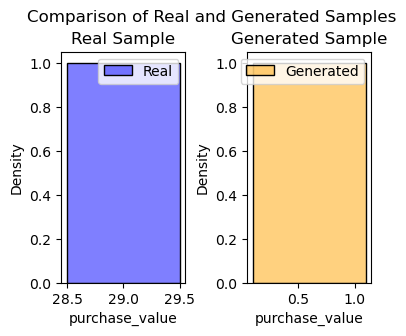

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize samples
def visualize_samples(real_samples, generated_samples, features_to_compare=None):
    if features_to_compare is None:
        features_to_compare = real_samples.columns[:5]  # Select the first 5 features by default

    num_features = len(features_to_compare)

    fig, axes = plt.subplots(nrows=1, ncols=2 * num_features, figsize=(4 * num_features, 3), gridspec_kw={'wspace': 0.5})
    fig.suptitle('Comparison of Real and Generated Samples', y=1.02)

    # Plot real samples
    for j, feature in enumerate(features_to_compare):
        sns.histplot(real_samples[feature], ax=axes[j], kde=True, color='blue', label='Real', stat='density')
        axes[j].set_title(f'Real Sample')
        axes[j].legend()

    
    # Plot generated samples
    for j, feature in enumerate(features_to_compare):
        sns.histplot(generated_samples[feature], ax=axes[num_features + j], kde=True, color='orange', label='Generated', stat='density')
        axes[num_features + j].set_title(f'Generated Sample')
        axes[num_features + j].legend()
    

    plt.tight_layout()
    plt.show()

# Assuming X_train and generated_data_df are DataFrames with credit card fraud data
# You can customize features_to_compare based on the features in your dataset

# Define features_to_compare
#features_to_compare = X_train.columns  # Compare all features
feature_to_visualize = 'purchase_value'

# Visualize samples from the first row of real and generated data
#visualize_samples(X_train.head(1), generated_data_df.head(1), features_to_compare=features_to_compare)
visualize_samples(X_train.head(1), generated_data_df.head(1), features_to_compare=[feature_to_visualize])

/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

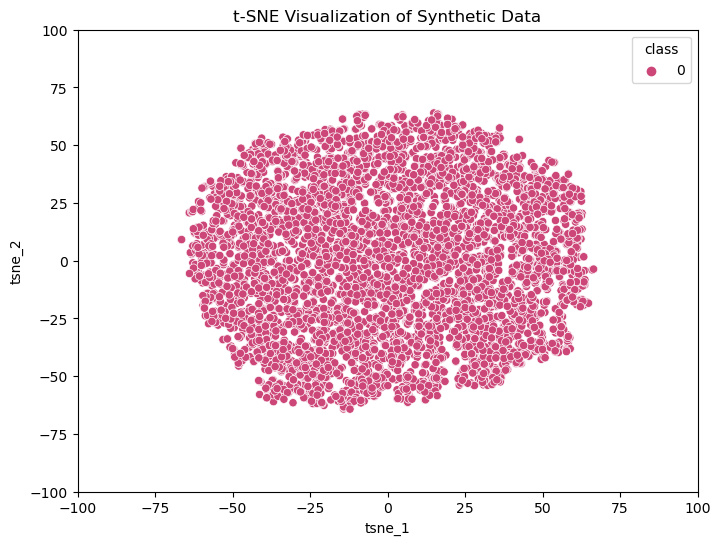

In [3]:
from sklearn.manifold import TSNE

# Apply t-SNE to the synthetic data
tsne = TSNE(n_components=2, random_state=42)
synthetic_data_tsne = tsne.fit_transform(synthetic_data)

# Create a DataFrame for t-SNE results
df_tsne = pd.DataFrame(data=synthetic_data_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['class'] = 0  

# Visualize t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='class', data=df_tsne, palette='plasma')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.title('t-SNE Visualization of Synthetic Data')
plt.show()

/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_cat

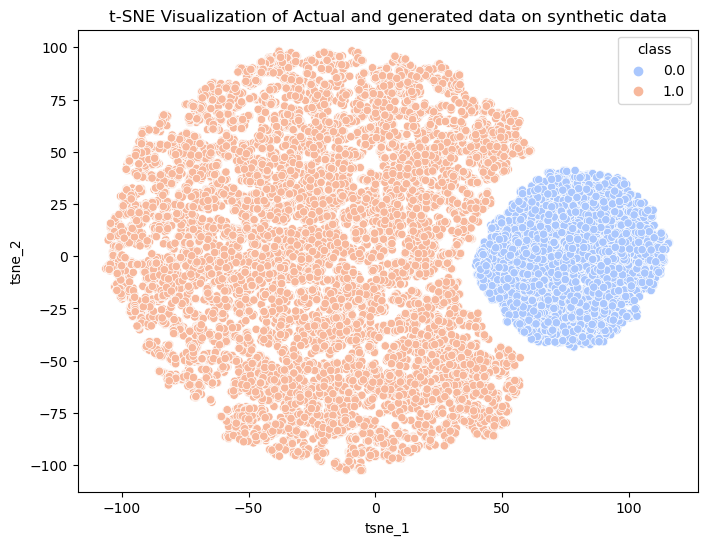

In [4]:
real_and_synthetic_data = pd.concat([X_train, pd.DataFrame(synthetic_data, columns=X_train.columns)], ignore_index=True)

# Apply t-SNE to the combined data
tsne = TSNE(n_components=2, random_state=42)
real_and_synthetic_data_tsne = tsne.fit_transform(real_and_synthetic_data)

# Create a DataFrame for t-SNE results
df_tsne = pd.DataFrame(data=real_and_synthetic_data_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['class'] = np.concatenate([np.ones(X_train.shape[0]), np.zeros(synthetic_data.shape[0])])  # 1 for real, 0 for synthetic

# Visualize t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='class', data=df_tsne, palette='coolwarm')
plt.title('t-SNE Visualization of Actual and generated data on synthetic data')
plt.show()

/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/farhatlamiabarsha/anaconda3/envs/gan/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_cat

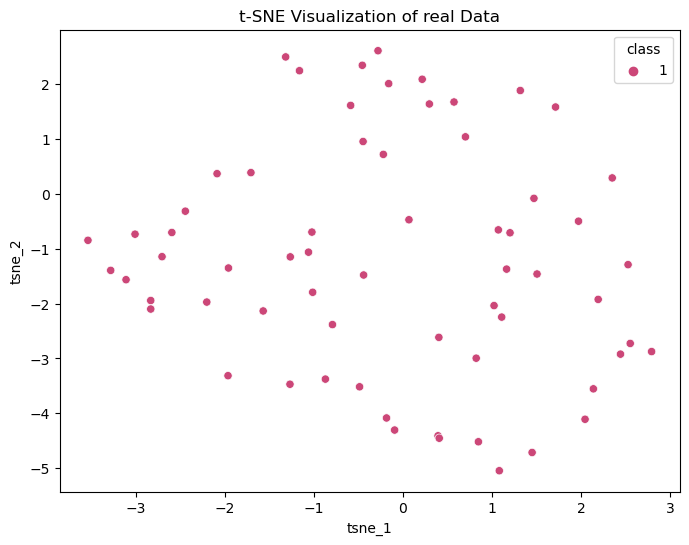

In [38]:

# Apply t-SNE to the synthetic data
tsne = TSNE(n_components=2, random_state=42)
real_data_tsne = tsne.fit_transform(real_data)

# Create a DataFrame for t-SNE results
df_tsne = pd.DataFrame(data=real_data_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['class'] = 1  # Assign a class label for real data (1 for real)

# Visualize t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='class', data=df_tsne, palette='plasma')
plt.title('t-SNE Visualization of real Data')
plt.show()

In [70]:
# Calculate Wasserstein distance between synthetic_data1 and synthetic_data2
wasserstein_distance_value_synthetic = calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2)
print(f"Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: {wasserstein_distance_value_synthetic}")

Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: 0.001040487816690734


In [71]:
import pandas as pd

df = pd.read_csv('/Users/farhatlamiabarsha/Downloads/archive/Fraud_Data.csv')

# Select 100 random rows from the original dataset
new_dataset = df.sample(n=500, random_state=42)  

# Specify the file path where you want to save the new dataset
output_file_path = '/Users/farhatlamiabarsha/Downloads/new_dataset1.csv'  

# Save the new dataset to a CSV file
new_dataset.to_csv(output_file_path, index=False)

print(f"New dataset saved to: {output_file_path}")

New dataset saved to: /Users/farhatlamiabarsha/Downloads/new_dataset1.csv


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import wasserstein_distance  # Import Wasserstein distance

# Function to create the GAN
def build_gan(latent_dim):
    generator = models.Sequential([
        layers.Dense(128, input_shape=(latent_dim,), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(X_train.shape[1], activation='sigmoid')  # Output layer
    ])

    discriminator = models.Sequential([
        layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Output layer
    ])

    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = models.Model(gan_input, gan_output)

    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return generator, discriminator, gan

# Function to calculate Wasserstein distance
def calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2):
    # Compute the Wasserstein distance
    distance = wasserstein_distance(synthetic_data1.flatten(), synthetic_data2.flatten())
    return distance

# dataset loading
df = pd.read_csv('/Users/farhatlamiabarsha/Downloads/new_dataset1.csv')

# Preprocess data 
columns_to_drop = ['user_id', 'signup_time', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['year'] = df['purchase_time'].dt.year
df['month'] = df['purchase_time'].dt.month
df['day'] = df['purchase_time'].dt.day
df['hour'] = df['purchase_time'].dt.hour
df['minute'] = df['purchase_time'].dt.minute
df['second'] = df['purchase_time'].dt.second
df = df.drop('purchase_time', axis=1)
new_column_order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'purchase_value', 'class']
df = df[new_column_order]

# Downsampling the majority class (non-fraud) to match the number of fraud cases
non_fraud = df[df['class'] == 0].sample(df['class'].value_counts()[1])
fraud = df[df['class'] == 1]
df = pd.concat([fraud, non_fraud], ignore_index=True)

# Split the dataset into dependent and independent variables
X = df.drop(['class'], axis=1)
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Build and train the GAN
latent_dim = 100
generator, discriminator, gan = build_gan(latent_dim)

# Training the GAN
epochs = 10000
batch_size = 64

min_loss = float('inf')

# Lists to store generator and discriminator losses
generator_losses = []
discriminator_losses = []

for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    generated_data = generator.predict(noise)
    
    idx_real = np.random.randint(0, X_train.shape[0], size=batch_size)
    real_data = X_train.iloc[idx_real]
    
    X_discriminator = np.concatenate([real_data, generated_data])
    y_discriminator = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    d_loss = discriminator.train_on_batch(X_discriminator, y_discriminator)
    
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    y_generator = np.ones((batch_size, 1))
    
    g_loss = gan.train_on_batch(noise, y_generator)
    
    # Append losses to the lists
    generator_losses.append(g_loss[0])
    discriminator_losses.append(d_loss[0])
    
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss[0]}")
    
    if epoch > 10 and epoch % 10 == 0:
        current_loss = g_loss[0]  # You may adjust this based on your preference
        if current_loss > min_loss:
            print(f"Early stopping at epoch {epoch} due to lack of improvement.")
            break
        else:
            min_loss = current_loss 

# After GAN training
latent_dim = 100
generator, _, _ = build_gan(latent_dim)

# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
noise1 = np.random.normal(0, 1, size=[num_samples, latent_dim])
noise2 = np.random.normal(0, 1, size=[num_samples, latent_dim])

synthetic_data1 = generator.predict(noise1)
synthetic_data2 = generator.predict(noise2)

# Calculate Wasserstein distance between synthetic_data1 and synthetic_data2
wasserstein_distance_value_synthetic = calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2)
print(f"Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: {wasserstein_distance_value_synthetic}")


# Continue with the rest of your code...
# ...
# Generate synthetic data using the trained generator
num_samples = X_test.shape[0]
synthetic_data = generator.predict(np.random.normal(0, 1, size=[num_samples, latent_dim]))

# Combine real and synthetic data
X_combined = pd.concat([X_train, pd.DataFrame(synthetic_data, columns=X_train.columns)], ignore_index=True)
y_combined = pd.concat([y_train, pd.Series(np.zeros(num_samples), name='class')], ignore_index=True)

# Train model
fraud_detection_model = LogisticRegression()
fraud_detection_model.fit(X_combined, y_combined)

# Evaluate the model on the test set
y_pred = fraud_detection_model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


2024-01-24 12:19:29.281877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:29.415020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]


Epoch 0, Discriminator Loss: 39.992088317871094, Generator Loss: 0.7750259637832642
2/2 [==============================] - 0s 937us/step


2024-01-24 12:19:29.682688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:29.684674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:29.701883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 768us/step
Epoch 10, Discriminator Loss: 47.90016555786133, Generator Loss: 0.79551100730896
2/2 [==============================] - 0s 946us/step


2024-01-24 12:19:29.888627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:29.890786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:29.910303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 698us/step
Epoch 20, Discriminator Loss: 47.87403869628906, Generator Loss: 0.7748515605926514
2/2 [==============================] - 0s 917us/step


2024-01-24 12:19:30.096497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:30.098786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:30.120484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

2/2 [==============================] - 0s 987us/step
Epoch 30, Discriminator Loss: 43.26385498046875, Generator Loss: 0.7813842296600342
Early stopping at epoch 30 due to lack of improvement.
1/1 [==============================] - 0s 8ms/step
Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: 0.013933423492643569
1/1 [==============================] - 0s 7ms/step


2024-01-24 12:19:30.311572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:30.313730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1]
	 [[{{node Placeholder/_1}}]]
2024-01-24 12:19:30.333869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [128,1]

In [73]:
# Calculate Wasserstein distance between synthetic_data1 and synthetic_data2
wasserstein_distance_value_synthetic = calculate_wasserstein_distance_between_synthetic(synthetic_data1, synthetic_data2)
print(f"Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: {wasserstein_distance_value_synthetic}")

Wasserstein Distance between Synthetic Data 1 and Synthetic Data 2: 0.013933423492643569
